In [23]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder.appName("BigDataProject").getOrCreate()

df = spark.read.csv("cleaned.csv", header=True, inferSchema=True)

In [24]:
# check for any needed data type normalization
df.dtypes

[('FL_DATE', 'date'),
 ('OP_CARRIER', 'string'),
 ('OP_CARRIER_FL_NUM', 'int'),
 ('ORIGIN', 'string'),
 ('DEST', 'string'),
 ('CRS_DEP_TIME', 'double'),
 ('DEP_TIME', 'double'),
 ('DEP_DELAY', 'double'),
 ('TAXI_OUT', 'double'),
 ('WHEELS_OFF', 'double'),
 ('WHEELS_ON', 'double'),
 ('TAXI_IN', 'double'),
 ('CRS_ARR_TIME', 'double'),
 ('ARR_TIME', 'double'),
 ('ARR_DELAY', 'double'),
 ('CANCELLED', 'double'),
 ('CANCELLATION_CODE', 'string'),
 ('DIVERTED', 'double'),
 ('CRS_ELAPSED_TIME', 'double'),
 ('ACTUAL_ELAPSED_TIME', 'double'),
 ('AIR_TIME', 'double'),
 ('DISTANCE', 'double'),
 ('CARRIER_DELAY', 'double'),
 ('WEATHER_DELAY', 'double'),
 ('NAS_DELAY', 'double'),
 ('SECURITY_DELAY', 'double'),
 ('LATE_AIRCRAFT_DELAY', 'double')]

In [25]:
from pyspark.sql.functions import year, month, dayofmonth, dayofweek,col

df = df.withColumn("YEAR", year(col("FL_DATE"))) \
       .withColumn("MONTH", month(col("FL_DATE"))) \
       .withColumn("DAY", dayofmonth(col("FL_DATE"))) \
       .withColumn("DAY_OF_WEEK", dayofweek(col("FL_DATE")))

In [26]:
print(df.columns)

['FL_DATE', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK']


In [27]:
df.filter((col("ARR_DELAY") > 0) & (col("DEP_DELAY") <= 0)).count()

6597136

In [28]:
df.filter((col("ARR_DELAY") <= 0) & (col("DEP_DELAY") > 0)).count()

6201138

In [29]:
from pyspark.sql.functions import when, col

from pyspark.sql.functions import when, col

df = df.withColumn(
    "DELAY_STATUS",
    when((col("CANCELLED") == 0.0) & (col("DEP_DELAY") <= 0) & (col("ARR_DELAY") <= 0), "On-Time")
    .when((col("CANCELLED") == 0.0) & (col("DEP_DELAY") > 0) & (col("ARR_DELAY") <= 0), "Delayed at Departure")
    .when((col("CANCELLED") == 0.0) & (col("DEP_DELAY") <= 0) & (col("ARR_DELAY") > 0), "Delayed at Arrival")
    .when((col("CANCELLED") == 0.0) & (col("DEP_DELAY") > 0) & (col("ARR_DELAY") > 0), "Delayed at Both Ends")
    .otherwise("None")  # Canceled flights will get NULL
)


In [30]:
def remove_outliers_iqr(df, column):
    q1, q3 = df.approxQuantile(column, [0.25, 0.75], 0.05)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

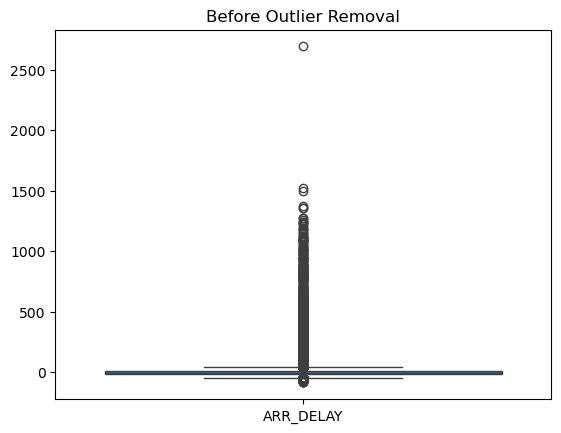

✅ Cleaned outliers in: DEP_DELAY
✅ Cleaned outliers in: ARR_DELAY
✅ Cleaned outliers in: CARRIER_DELAY
✅ Cleaned outliers in: WEATHER_DELAY
✅ Cleaned outliers in: NAS_DELAY
✅ Cleaned outliers in: SECURITY_DELAY
✅ Cleaned outliers in: LATE_AIRCRAFT_DELAY


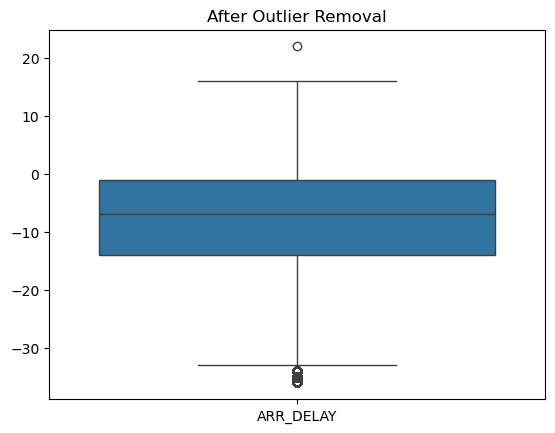

In [31]:
columns_to_check = [
 'DEP_DELAY','ARR_DELAY', 'CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY'
]

import seaborn as sns
import matplotlib.pyplot as plt
# BEFORE
sample_raw = df.select('ARR_DELAY').sample(fraction=0.01,seed = 42).toPandas()
sns.boxplot(data=sample_raw)
plt.title("Before Outlier Removal")
plt.show()

# Apply outlier filtering
for col_name in columns_to_check:
    try:
        df = remove_outliers_iqr(df, col_name)
        print(f"✅ Cleaned outliers in: {col_name}")
    except Exception as e:
        print(f"⚠️ Skipped {col_name} due to error: {e}")

# AFTER
sample_clean = df.select('ARR_DELAY').sample(fraction=0.01, seed = 42).toPandas()
sns.boxplot(data=sample_clean)
plt.title("After Outlier Removal")
plt.show()

In [33]:
df.write.option("header", True).csv("preprocessed_version.csv")